# Analysis of empirical AEA data set from Peter *et al.* 2016 

See https://github.com/NovembreLab/eems-around-the-world/blob/master/ for more information (data set from Fig 1). It has about ~4,700 individuals, the goal is to see if the Madagascar population can be connected with a long range edge (i.e., does it show high residual with default `feems` fit?)

### Imports

In [217]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from datetime import date
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
from copy import deepcopy
import itertools as it
import statsmodels.api as sm
from scipy.stats.distributions import chi2
from sklearn.metrics.pairwise import haversine_distances
from scipy.spatial.distance import pdist, squareform

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

# feems
from feems.utils import prepare_graph_inputs
from feems.spatial_graph import query_node_attributes
from feems import SpatialGraph, Viz, Objective
from feems.cross_validation import run_cv, comp_mats
from feems.helper_funcs import cov_to_dist, comp_genetic_vs_fitted_distance, plot_default_vs_long_range

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data wrangling to get `.coord` file

The coordinates are in the `.pop_geo` file and the population order is in the `.pop_order` file. The individual meta-data is in the `.indiv_meta` file (sampleID, popID, which study, etc.) -- need to put these things together into 1 file. 

In [8]:
data_path = pkg_resources.resource_filename("feems", "data/AEA")

location_data = pd.read_csv("{}/c1global1nfd.pop_geo".format(data_path))
sample_data = pd.read_csv("{}/c1global1nfd.indiv_meta".format(data_path))
order = pd.read_table("{}/c1global1nfd.order".format(data_path), header=None, sep=" ")

meta_data = sample_data.merge(location_data)

# aseed = int(date.today().strftime("%Y%m%d"))
# np.random.seed(aseed)

# sd = meta_data['accuracy'] * 0.0000001 + 0.00001 # accuracy * 'sdfactor' + EPS
# long_jitter = np.random.normal(meta_data['longitude'], sd)
# lat_jitter = np.random.normal(meta_data['latitude'], sd)
# long_jitter = ["%2.2f" % i for i in long_jitter]
# lat_jitter = ["%2.2f" % i for i in lat_jitter]
# temp_data = pd.DataFrame({'longitude':long_jitter,
#                             'latitude': lat_jitter})
# temp_data.to_csv("~/feems/feems/data/AEA/c1global1nfd-%d.coord"%int(date.today().strftime("%Y%m%d")), sep=" ", header=False, index=False,
#                     columns=('longitude', 'latitude'))

## Reading in the data

In [9]:
(bim, fam, G) = read_plink("{}/c1global1nfd".format(data_path))

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 24.76it/s]


In [10]:
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

n_samples=4697, n_snps=19954


In [11]:
%%time
# setup graph
coord = np.loadtxt("{}/c1global1nfd-{}.coord".format(data_path,'20210708'))  # sample coordinates
outer = np.loadtxt("{}/c1global1nfd.outer".format(data_path))  # outer coordinates
grid_path = "/Users/vivaswat/feems/feems/data/grid_250.shp" # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=False, 
                                             buffer=0,
                                             outer=outer)

CPU times: user 21.7 s, sys: 146 ms, total: 21.8 s
Wall time: 22 s


In [12]:
#outer = np.loadtxt("{}/c1global1nfd.outer".format(data_path))  # outer coordinates
np.max(outer[:,1])

77.449952

In [13]:
genotypes[:,np.random.choice(np.arange(genotypes.shape[1]),genotypes.shape[1],replace=False)].shape

(4697, 19954)

In [14]:
%%time
# resampling the genotypes array...
sp_graph = SpatialGraph(genotypes[:,np.random.choice(np.arange(genotypes.shape[1]),genotypes.shape[1],replace=False)], coord, grid, edges)

CPU times: user 11min 10s, sys: 31.8 s, total: 11min 42s
Wall time: 11min 42s


In [15]:
projection = ccrs.PlateCarree(central_longitude=80.0)

In [ ]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=2, 
        obs_node_size=1.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

In [61]:
%%time
# define grids
# reverse the order of lambdas and alphas for warmstart
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]

# # run cross-validation
# cv_err = run_cv(sp_graph, lamb_grid, n_folds=10, factr=1e10)

# # average over folds
# mean_cv_err = np.mean(cv_err, axis=0)

# # argmin of cv error
# lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])

CPU times: user 399 µs, sys: 918 µs, total: 1.32 ms
Wall time: 1.31 ms


In [16]:
sp_graph.fit(lamb = 10.5)

constant-w/variance fit, converged in 138 iterations, train_loss=-1419354.4568558
lambda=10.50000, alpha=0.31156, beta=0.00000, converged in 160 iterations, train_loss=-2012757.60800


In [26]:
max_res_nodes = comp_genetic_vs_fitted_distance(sp_graph, n_lre=20, lamb=10.5, plotFig=False)
max_res_nodes

[(274, 296),
 (273, 296),
 (272, 296),
 (144, 296),
 (267, 296),
 (195, 296),
 (156, 296),
 (269, 296),
 (189, 296),
 (284, 296),
 (179, 296),
 (192, 296),
 (185, 296),
 (186, 296),
 (188, 296),
 (223, 296),
 (289, 296),
 (174, 296),
 (19, 296),
 (88, 296)]

In [ ]:
sample_data.loc[sample_data['popId']==753,:]

In [ ]:
os.path.commonprefix([sample_data['sampleId'][sample_data['popId']==popid[0]] for popid in node_to_pop.iloc[np.ravel(max_res_nodes[0]),1]])

In [ ]:
np.unique(sample_data['popId'].values)

In [179]:
#os.path.commonprefix(sample_data['sampleId'][sample_data['popId']==217].values.tolist())
#os.path.commonprefix(['EstoniansMadMA317', 'EstoniansMadMA318', 'EstoniansMadMA320','EstoniansMadMA335', 'EstoniansMadMA337', 'EstoniansMadMA338'])
[os.path.commonprefix(sample_data['sampleId'][sample_data['popId']==popid].values.tolist()[0:2]) for popid in [2,6,8]]

['EstoniansEthiopiaOr4', 'EstoniansmoroccoA', 'EstoniansGRC1211809']

In [ ]:
[sample_data['sampleId'][sample_data['popId']==popid].values.tolist() for popid in [2,6,8]]

In [ ]:
len([os.path.commonprefix(sample_data['sampleId'][sample_data['popId']==popid[0]].values.tolist()[0:2]) for popid in node_to_pop['pops']])

In [ ]:
## creating a heatmap widget with plotly for the residual matrix
# #sp_graph.fit(lamb=lamb_cv)
# obj = Objective(sp_graph)
# fit_cov, _, emp_cov = comp_mats(obj)
# fit_dist = cov_to_dist(fit_cov)[tril_idx]
# emp_dist = cov_to_dist(emp_cov)[tril_idx]

# X = sm.add_constant(fit_dist)
# mod = sm.OLS(emp_dist, X)
# res = mod.fit()

resnode = np.zeros((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes))
#resnode[np.tril_indices_from(resnode, k=-1)] = 1.0#res.resid
resnode[np.triu_indices_from(resnode, k=0)] = np.nan
resnode[np.tril_indices_from(resnode, k=-1)] = res.resid
# mask = np.zeros_like(resnode, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# max_res_pops = [os.path.commonprefix(sample_data['sampleId'][sample_data['popId']==popid[0]].values.tolist()) for popid in node_to_pop.iloc[np.ravel(max_res_nodes[0:3]),1]]
# labs = [os.path.commonprefix(sample_data['sampleId'][sample_data['popId']==popid[0]].values.tolist()[0:2]) for popid in node_to_pop['pops']]
fig = px.imshow(resnode, color_continuous_scale='balance_r', color_continuous_midpoint=0, x=labs, y=labs, title='Residual matrix', labels={'color':'residual'})
fig.update_layout(font_family='Arial')
# fig.add_annotation(xref="x domain", yref='y domain', x=1.4, y=0.9, text="Top 3 pairs:<br>1. {}<br>2. {}<br>3. {}".format(max_res_pops[0:2], max_res_pops[2:4], max_res_pops[4:6]), showarrow=False)
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
#fig.write_html('AEA_residmat.html')

In [194]:
## getting coordinates of pops with very low covariance
# lg = [np.array(location_data.loc[location_data['popId']==popid[0],'longitude']) for popid in node_to_pop.iloc[70:110,1]]
# lg = [lg[0] for lg in lg]
# lt = [np.array(location_data.loc[location_data['popId']==popid[0],'latitude']) for popid in node_to_pop.iloc[70:110,1]]
# lt = [lt[0] for lt in lt]
## getting coordinates of all pops
lg = [np.array(location_data.loc[location_data['popId']==popid[0],'longitude']) for popid in node_to_pop.iloc[np.arange(297),1]]
lg = [lg[0] for lg in lg]
lt = [np.array(location_data.loc[location_data['popId']==popid[0],'latitude']) for popid in node_to_pop.iloc[np.arange(297),1]]
lt = [lt[0] for lt in lt]

poplabs = [os.path.commonprefix(sample_data['sampleId'][sample_data['popId']==popid[0]].values.tolist()) for popid in node_to_pop.iloc[np.arange(297),1]]

In [198]:
# sample_data['sampleId'][sample_data['popId']==523].values.tolist()[0]
node_to_pop['pops']

0           [523]
1           [524]
2           [505]
3           [597]
4           [490]
          ...    
292         [780]
293         [453]
294         [308]
295    [309, 769]
296         [753]
Name: pops, Length: 297, dtype: object

In [201]:
# import plotly.express as px
# px.scatter_geo(lat=lt,lon=lg,title='pops with low covariance')

In [249]:
## computing genetic and geographic distances
# D_geno = squareform(pdist(genotypes, metric="sqeuclidean")) / genotypes.shape[1]
# coord_rad = coord[:,::-1] * np.pi / 180.0
# D_geo = haversine_distances(np.vstack((lt,lg)).T * np.pi/180.) * 6371
emp_dist = cov_to_dist(emp_cov)

In [296]:
# print(D_geo[269,np.arange(250,261)])
# D_geo[296,np.arange(275,283)]
print(emp_dist[np.arange(272,275),104])
emp_dist[293,294]

[2.13949179 2.12265326 2.09730291]


1.743917158304256

In [247]:
## plotting the populations on interactive map with their IDs and names for convenience of looking them up
px.scatter_geo(lat=lt,lon=lg,title='all pops for ease of use',text=np.arange(297),hover_name=['{},{}'.format(np.ravel(node_to_pop['pops'][i]),poplabs[i]) for i in np.arange(297)],fitbounds='locations',projection='conic equidistant')
# ?px.scatter_geo

constant-w/variance fit, converged in 138 iterations, train_loss=-1419354.4568558
lambda=10.50000, alpha=0.31156, beta=0.00000, converged in 160 iterations, train_loss=-2012757.60800


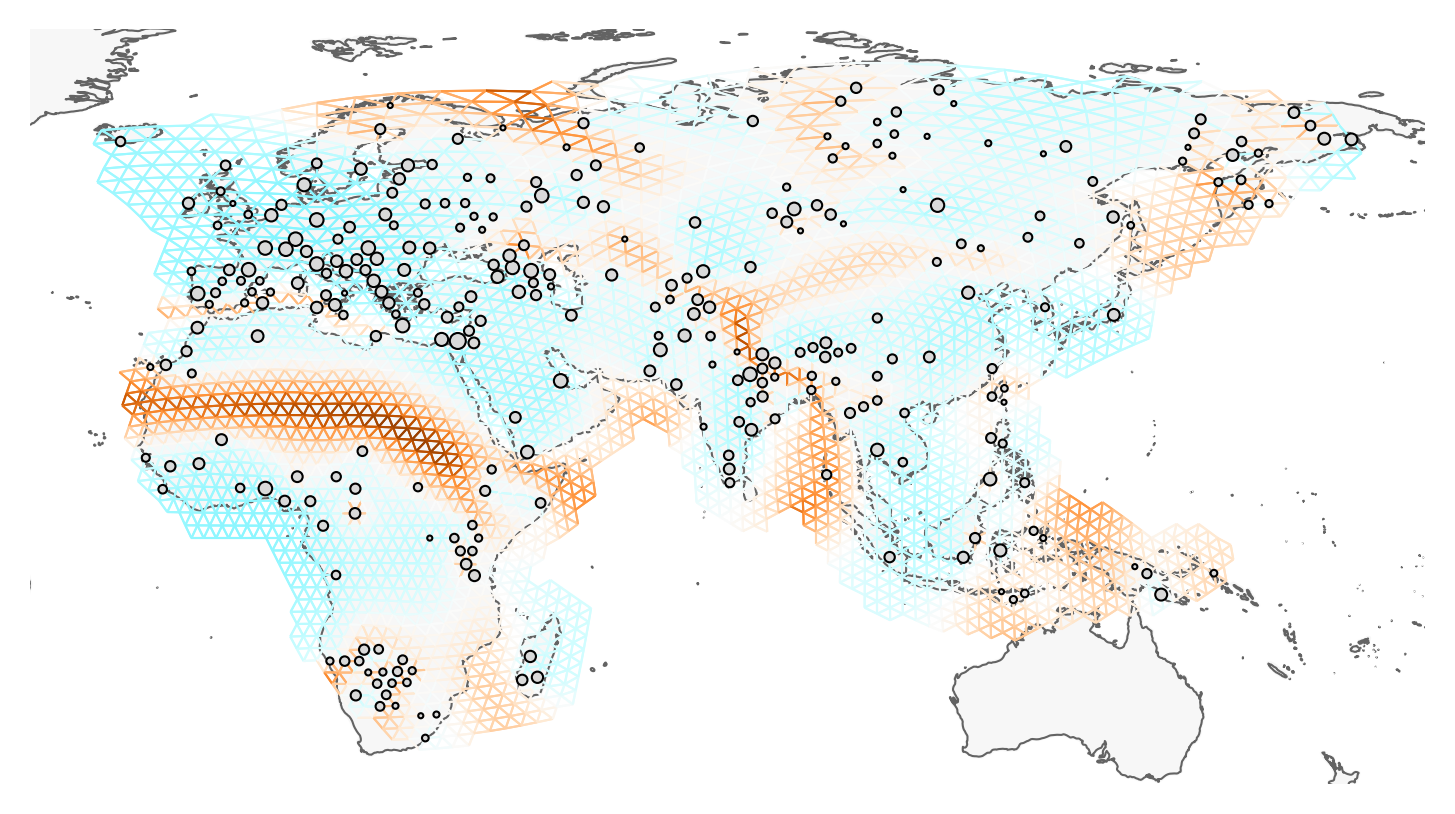

In [215]:
sp_graph.fit(lamb=10.5)
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=1.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
#plt.savefig('~/feems/AEA-lambdacv.png')

In [18]:
permuted_idx = query_node_attributes(sp_graph, "permuted_idx")
obs_perm_ids = permuted_idx[: sp_graph.n_observed_nodes]

In [19]:
## code for mapping nodes back to populations (since multiple pops can be assigned to the same nodes)
node_to_pop = pd.DataFrame(index = np.arange(sp_graph.n_observed_nodes), columns = ['nodes', 'pops'])
node_to_pop['nodes'] = obs_perm_ids
node_to_pop['pops'] = [np.unique(sample_data['popId'][query_node_attributes(sp_graph,"sample_idx")[x]]) for x in obs_perm_ids]

In [14]:
node_to_pop.iloc[np.ravel(max_res_nodes),1].values.reshape(len(max_res_nodes),2)

array([[array([217]), array([753])],
       [array([219]), array([753])],
       [array([218]), array([753])],
       [array([283]), array([753])],
       [array([505]), array([753])],
       [array([790]), array([753])],
       [array([791]), array([753])],
       [array([283]), array([217])],
       [array([6]), array([753])],
       [array([568]), array([753])],
       [array([505]), array([283])],
       [array([285, 405]), array([753])],
       [array([1021]), array([753])],
       [array([283]), array([219])],
       [array([283]), array([218])],
       [array([573]), array([753])],
       [array([404]), array([753])],
       [array([372]), array([753])],
       [array([538]), array([753])],
       [array([217]), array([309, 769])]], dtype=object)

In [181]:
#[popid[0] for popid in node_to_pop.iloc[np.ravel(max_res_nodes),1]]
#[sample_data['sampleId'][sample_data['popId']==popid[0]] for popid in node_to_pop.iloc[np.ravel(max_res_nodes)[0:40],1]]
#[location_data[['latitude','longitude']][location_data['popId']==popid[0]] for popid in node_to_pop.iloc[np.ravel(max_res_nodes[21:24]),1]]
[location_data[['latitude','longitude']][location_data['popId']==popid[0]] for popid in node_to_pop.iloc[np.ravel([(52,85)]),1]]

[     latitude  longitude
 300      39.4       15.5,
      latitude  longitude
 213       1.0       29.0]

In [176]:
#print(max_res_nodes)
for x in node_to_pop['nodes'][np.ravel(max_res_nodes)[0:20]].values.reshape(10,2):
    print((x[0],x[1]))

KeyError: 'key of type tuple not found and not a MultiIndex'

In [ ]:
#tuple(map(tuple,node_to_pop['nodes'][np.ravel(max_res_nodes)[0:40]].values.reshape(20,2)))
list(map(tuple,node_to_pop['nodes'][np.ravel(max_res_nodes)[0:100]].values.reshape(50,2)))

In [ ]:
list(map(tuple,node_to_pop['nodes'][np.ravel(max_res_nodes)[0:12]].values.reshape(6,2)))

### Adding the above edges to the graph 

Here, I will add the 6 edges (3 Madagascar - 2 Papuan) to the previous graph and check for new top residuals from this fit (after accounting for the long range ones, what is left over?)

In [63]:
# lrn = list(it.product((2323,2312,2310),(2738,2696)))
# lrn = list(map(tuple,node_to_pop['nodes'][np.ravel(max_res_nodes)[0:20]].values.reshape(10,2)))
# edges_lr = deepcopy(edges)
# edges_lr = edges_lr.tolist()
# for x in lrn:
#     edges_lr.append(list(tuple(y+1 for y in x)))
# # resampling the genotypes matrix
# sp_graph_lr = SpatialGraph(genotypes[:,np.random.choice(np.arange(genotypes.shape[1]),genotypes.shape[1],replace=False)], coord, grid, np.array(edges_lr), long_range_edges=lrn)

cv_err_lr = run_cv(sp_graph_lr, lamb_grid, n_folds=20, factr=1e10)

# # average over folds
mean_cv_err_lr = np.mean(cv_err_lr, axis=0)

# # argmin of cv error
lamb_cv_lr = float(lamb_grid[np.argmin(mean_cv_err_lr)])


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 alpha=1/1
 fold= 10
iteration lambda=20/20 alpha=1/1
 fold= 11
iteration lambda=20/20 alpha=1/1
 fold= 12
iteration lambda=20/20 alpha=1/1
 fold= 13
iteration lambda=20/20 alpha=1/1
 fold= 14
iteration lambda=20/20 alpha=1/1
 fold= 15
iteration lambda=20/20 alpha=1/1
 fold= 16
iteration lambda=20/20 alpha=1/1
 fold= 17
iteration lambda=20/20 alpha=1/1
 fold= 18
iteration lambda=20/20 alpha=1/1
 fold= 19
iteration lambda=20/20 alpha=1/1

### Comparing the covariance matrices of the fits

Checking to see if by adding the long range edges we decrease the covariance of the fits (as expected if the long range edges are *real*). 

In [120]:
# obj = Objective(sp_graph)
# fit_cov, _, emp_cov = comp_mats(obj)
sp_graph_lr.fit(lamb = lamb_cv_lr)
obj_lr = Objective(sp_graph_lr)
fit_cov_lr, _, emp_cov_lr = comp_mats(obj_lr)

diff_mat = fit_cov - emp_cov
diff_mat_lr = fit_cov_lr - emp_cov_lr

constant-w/variance fit, converged in 135 iterations, train_loss=-1328607.6025638
lambda=2.06914, alpha=0.34432, beta=0.00000, converged in 124 iterations, train_loss=-2146825.15546


Text(0.5, 1.0, 'Absolute residual')

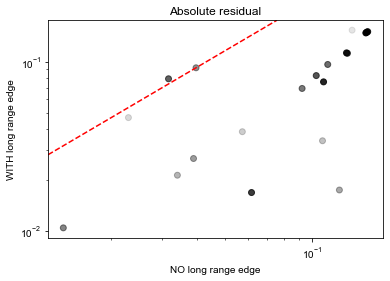

In [134]:
plt.scatter(np.abs([diff_mat[x] for x in max_res_nodes]), np.abs([diff_mat_lr[x] for x in max_res_nodes]), color='k', alpha=np.linspace(1,0.1,20)[np.argsort(np.abs([diff_mat[x] for x in max_res_nodes]))[::-1]])
mk = np.array([diff_mat[x] for x in max_res_nodes]) < 0
# plt.scatter(np.abs([diff_mat[x] for x in list(it.compress(max_res_nodes, mk))]), np.abs([diff_mat_lr[x] for x in list(it.compress(max_res_nodes, mk))]), color='cadetblue')
plt.loglog()
plt.axline((0,0),(np.max([diff_mat[x] for x in max_res_nodes]),np.max([diff_mat_lr[x] for x in max_res_nodes])), color='red', ls='--')
plt.xlabel('NO long range edge')
plt.ylabel('WITH long range edge')
plt.title('Absolute residual')

In [165]:
# np.linspace(1,0.2,20)
# np.argpartition(diff_mat,1)[:4,:4]
for k in np.argpartition(diff_mat[tril_idx],3)[:3]:
    x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1
    y = np.int(k - 0.5*x*(x-1))
    print(x,y)

87 86
91 86
91 87


In [174]:
for k in np.argpartition(np.reshape(np.arange(9)[::-1],(3,3))[np.tril_indices(3)],3)[:3]:
    x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1
    y = np.int(k - 0.5*x*(x-1))
    print(x,y)    

3 0
3 2
3 1


In [173]:
np.reshape(np.arange(9)[::-1],(3,3))

array([[8, 7, 6],
       [5, 4, 3],
       [2, 1, 0]])

Text(0.5, 1.0, 'Absolute empirical covariance')

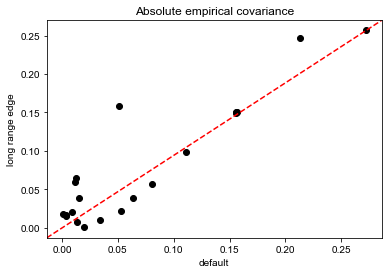

In [122]:
plt.scatter(np.abs([fit_cov[x] for x in max_res_nodes]), np.abs([fit_cov_lr[x] for x in max_res_nodes]), color='k')
plt.axline((0,0),(np.max([fit_cov[x] for x in max_res_nodes]),np.max([fit_cov_lr[x] for x in max_res_nodes])), color='red', ls='--')
plt.xlabel('default')
plt.ylabel('long range edge')
plt.title('Absolute fitted covariance')

In [ ]:
# sp_graph_lr.genotypes = genotypes[:,np.random.choice(np.arange(genotypes.shape[1]),genotypes.shape[1],replace=False)]
# sp_graph_lr.fit(lamb=8.5,beta=b)
plt.imshow(sp_graph_lr.S, cmap='Blues')
plt.colorbar()

In [ ]:
%%time
max_res_nodes_lr = comp_genetic_vs_fitted_distance(sp_graph_lr, n_lre=10, lamb=lamb_cv_lr, plotFig=False)

In [ ]:
sp_graph_lr.fit(lamb=10.5, beta=20.0)

In [ ]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph_lr, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=1.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)
# v.draw_edge_colorbar()

Text(0.5, 0, 'log of short range edge weights')

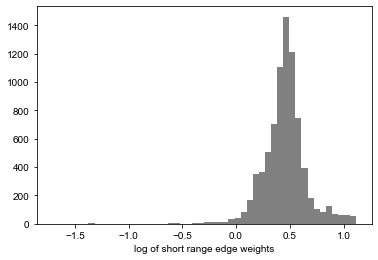

In [46]:
# sp_graph_lr.fit(lamb=5.5)
plt.hist(np.log10(sp_graph_lr.w[~sp_graph_lr.lre_idx]), color='grey', bins=50)
plt.xlabel('log of short range edge weights')

In [ ]:
# beta=250 -> array([2.12474393, 0.14835353, 1.55029175, 1.09754942, 0.95754866,2.40636459])
# beta=100 -> array([2.50686187, 0.34383033, 2.10272136, 1.69826122, 1.66707206, 2.73100875])
# beta=10 -> array([1.66858584, 0.14116015, 1.2337326 , 0.90418576, 0.78796067, 1.82486916])
# beta=1 -> array([1.70359834, 0.15216836, 1.26583358, 0.93705959, 0.81673611, 1.85113836])
# beta=0.1 -> array([1.7121089 , 0.16106014, 1.24869155, 0.93644284, 0.79337417, 1.82669711])
sp_graph_lr.w[[edges_lr.index([2324,2697]),edges_lr.index([2324,2739]),edges_lr.index([2313,2697]),edges_lr.index([2313,2739]),edges_lr.index([2311,2697]),edges_lr.index([2311,2739])]]

In [ ]:
print(np.where(sp_graph_lr.lre_idx==True))
[edges_lr.index([2324,2697]),edges_lr.index([2324,2739]),edges_lr.index([2313,2697]),edges_lr.index([2313,2739]),edges_lr.index([2311,2697]),edges_lr.index([2311,2739])]

In [ ]:
# storing the weight estimates for different betas
betas = np.logspace(-2,5,base=np.exp(1),num=25) # -0.01 to 400
# betadf = pd.DataFrame(index=range(len(betas)),columns=range(6)) # no of betas x no of lre
# for ib, b in enumerate(betas):
#     sp_graph_lr.fit(lamb=5.5, beta=b)
#     betadf.iloc[ib,:] = sp_graph_lr.w[sp_graph_lr.lre_idx]

In [ ]:
metricsdf

In [ ]:
# plotting a regularization path across a range of betas 
betadf['betas'] = betas
betadf.plot(x='betas',y=[0,2,4,1,3,5],kind='line',legend=None,cmap='gray')
plt.semilogx()
plt.ylabel('estimated long range edge weights')

In [ ]:
metricsdf2 = pd.DataFrame(index=range(len(betas)),columns=["loss","log_lik","pen1","pen2"])
metricsdf2['betas'] = betas
for ib, b in enumerate(betas):
    sp_graph_lr.fit(lamb=8.5, beta=b)
    metricsdf2.loc[ib,"loss"] = sp_graph_lr.train_loss
    obj_lr = Objective(sp_graph_lr)
    obj_lr.lamb = 8.5
    obj_lr.alpha = 1/sp_graph_lr.w0.mean()
    obj_lr.beta = b
    obj_lr.inv() 
    metricsdf2.loc[ib,"log_lik"] = -obj_lr.neg_log_lik()
    obj_lr.loss()
    metricsdf2.loc[ib,"pen1"] = obj_lr.pen1
    metricsdf2.loc[ib,"pen2"] = obj_lr.pen2#b * np.sum(sp_graph_lr.w[sp_graph_lr.lre_idx])

In [ ]:
# metricsdf.loc[:,"pen1"] = metricsdf.loc[:,"loss"] - metricsdf.loc[:,"log_lik"] - metricsdf.loc[:,"pen2"]
# metricsdf = deepcopy(metricsdf2)
# metricsdf = metricsdf + metricsdf2
metricsdf = metricsdf/4

In [ ]:
metricsdf2

In [ ]:
metricsdf

In [ ]:
metricsdf.plot(x='betas',y=["log_lik","pen1","pen2"],kind='line')
plt.ylabel('units')
plt.loglog()
metricsdf.plot(x='betas',y=["log_lik"],kind='line')
plt.semilogx()
metricsdf.plot(x='betas',y=['pen1'],kind='line',color='orange')
plt.semilogx()
metricsdf.plot(x='betas',y='loss')
plt.semilogx()
# metricsdf.plot(x='betas',y=["loss","log_lik"],kind='line')
# plt.semilogx()

In [ ]:
max_res_nodes

In [ ]:
## calculating the increase in the log-likelihood for adding each extra edge (do not penalize lre)
nll = np.empty(60)
edges_lr = deepcopy(edges)
edges_lr = edges_lr.tolist()
for idx in np.arange(len(nll)):
    for x in node_to_pop['nodes'][np.ravel(max_res_nodes)[idx*2:((idx+1)*2)]].values.reshape(1,2):
        #print([(x[0],x[1])])        
        edges_lr.append(list(tuple(y+1 for y in x)))    
    sp_graph_lr = SpatialGraph(genotypes, coord, grid, np.array(edges_lr))
    sp_graph_lr.fit(lamb=5.5)
    obj_lr = Objective(sp_graph_lr)
    obj_lr.inv()
    nll[idx] = obj_lr.neg_log_lik()

#np.savetxt("nll.txt",nll,delimiter='\n')

In [ ]:
len(sp_graph_lr.edges)

In [ ]:
#node_to_pop['nodes'][np.ravel(max_res_nodes)[idx*2:((idx+1)*2)]].values.reshape(1,2)
#np.ravel(max_res_nodes)[idx*2:((idx+1)*2)]
# consecutive diffs
#plt.plot(np.arange(1,40),[x - nll[i - 1] for i, x in enumerate(nll)][1:],'-')
# diff with first log-lik
# plt.plot(np.arange(0,60),nll[00:60]-nll[00],'-')
# plt.ylabel('change in log-lik units')
# plt.xlabel('number of edges')
# obj = Objective(sp_graph)
# obj.inv()
print(obj.neg_log_lik())
obj_lr.neg_log_lik()

In [ ]:
plt.matshow(sp_graph_lr.L.todense())

In [ ]:
#plt.matshow((sp_graph_lr.L-sp_graph_lr.L.todia()).todense())
plt.hist(np.ravel((sp_graph_lr.L-np.diag(sp_graph_lr.L.diagonal()))))

In [ ]:
plt.matshow(sp_graph_lr.L.todense()-np.diag(sp_graph_lr.L.diagonal()),cmap='viridis_r')
plt.colorbar()

In [ ]:
?plt.imshow

In [ ]:
node_to_pop['nodes'][np.ravel(max_res_nodes)[0:20]].values.reshape(10,2)

In [ ]:
node_to_pop.iloc[np.ravel(max_res_nodes_lr),1].values.reshape(10,2)

In [ ]:
comp_genetic_vs_fitted_distance(sp_graph, lamb=10.0, plotFig=True)

In [ ]:
comp_genetic_vs_fitted_distance(sp_graph_lr, lamb=lamb_cv_lr, plotFig=True)

In [ ]:
obj = Objective(sp_graph)
obj.inv()
obj_lr = Objective(sp_graph_lr)
obj_lr.inv()
if obj_lr.neg_log_lik() < obj.neg_log_lik():
    print("Model with long-range edges fits better than default by %.2f log units with p-value of %.2e"%(-2.*(obj_lr.neg_log_lik() - obj.neg_log_lik()),chi2.sf(-2.*(obj_lr.neg_log_lik() - obj.neg_log_lik()),1)))

In [ ]:
plt.hist(sp_graph_lr.w[sp_graph_lr.lre_idx])

In [ ]:
# sp_graph_lr.fit(lamb=10.,beta=10.)
# obj_lr.inv()
#sp_graph_lr.train_loss - obj_lr.neg_log_lik() - 
#10. * np.sum(sp_graph_lr.w[sp_graph_lr.lre_idx])
sp_graph_lr.w[sp_graph_lr.lre_idx]

In [ ]:
print(obj_lr.neg_log_lik())
obj.neg_log_lik()

In [ ]:
print(np.where(query_node_attributes(sp_graph,"n_samples")!=0))

In [ ]:
#[i for i in permuted_idx if 1710 in query_node_attributes(sp_graph,"sample_idx")[i]]
sample_data['sampleId']
query_node_attributes(sp_graph,"sample_idx")[10]

In [ ]:
max_res_nodes

In [ ]:
[np.unique(sample_data['popId'][query_node_attributes(sp_graph,"sample_idx")[x]]) for x in obs_perm_ids[0:3]]

In [ ]:
obs_perm_ids

## Subsetting other regions: Mediterranean + North African and Indian subcontinent 

Below, I will subset the data from these two regions to see if `feems` identifies local features that are not apparent in the global data set. This is actually available as a WEA data set from the paper. If only the Mediterranean is needed, I can subset based on a latitudinal cut-off ($>42^o$ N & $>40^o$ E)

In [ ]:
data_path = pkg_resources.resource_filename("feems", "data/WEA")

location_data = pd.read_csv("{}/c1eumedi1nf.pop_geo".format(data_path))
sample_data = pd.read_csv("{}/c1eumedi1nf.indiv_meta".format(data_path))
order = pd.read_table("{}/c1eumedi1nf.order".format(data_path), header=None, sep=" ")

meta_data = sample_data.merge(location_data)

# aseed = int(date.today().strftime("%Y%m%d"))
# np.random.seed(0)

sd = meta_data['accuracy'] * 0.0000001 + 0.00001 # accuracy * 'sdfactor' + EPS
long_jitter = np.random.normal(meta_data['longitude'], sd)
lat_jitter = np.random.normal(meta_data['latitude'], sd)
long_jitter = ["%2.2f" % i for i in long_jitter]
lat_jitter = ["%2.2f" % i for i in lat_jitter]
temp_data = pd.DataFrame({'longitude':long_jitter,
                            'latitude': lat_jitter})
temp_data.to_csv("~/feems/feems/data/WEA/c1eumedi1nf-%d.coord"%int(date.today().strftime("%Y%m%d")), sep=" ", header=False, index=False,
                    columns=('longitude', 'latitude'))

In [ ]:
(bim, fam, G) = read_plink("{}/c1eumedi1nf".format(data_path))

imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

In [ ]:
%%time
# setup graph
coord = np.loadtxt("{}/c1eumedi1nf-{}.coord".format(data_path,int(date.today().strftime("%Y%m%d"))))  # sample coordinates
outer = np.loadtxt("{}/c1eumedi1nf.outer".format(data_path))  # outer coordinates
grid_path = "/Users/vivaswat/feems/feems/data/grid_100.shp" # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=False, 
                                             buffer=0,
                                             outer=outer)

In [ ]:
%%time
sp_graph = SpatialGraph(genotypes, coord, grid, edges)

In [ ]:
projection = ccrs.PlateCarree(central_longitude=35.0)
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=2, 
        obs_node_size=1.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

In [ ]:
%%time
# define grids
# reverse the order of lambdas and alphas for warmstart
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]

# run cross-validation
cv_err = run_cv(sp_graph, lamb_grid, n_folds=10, factr=1e10)

# average over folds
mean_cv_err = np.mean(cv_err, axis=0)

# argmin of cv error
lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])

In [ ]:
sp_graph.fit(lamb = lamb_cv)

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=1.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)
fig.savefig("/Users/vivaswat/feems/WEA_lambcv.png", dpi=300)

In [ ]:
%%time
max_res_nodes = comp_genetic_vs_fitted_distance(sp_graph, n_lre=6, lamb=lamb_cv, plotFig=False)

In [ ]:
permuted_idx = query_node_attributes(sp_graph, "permuted_idx")
obs_perm_ids = permuted_idx[: sp_graph.n_observed_nodes]

# code for mapping nodes back to populations (since multiple pops can be assigned to the same nodes)
node_to_pop = pd.DataFrame(index = np.arange(sp_graph.n_observed_nodes), columns = ['nodes', 'pops'])
node_to_pop['nodes'] = obs_perm_ids
node_to_pop['pops'] = [np.unique(sample_data['popId'][query_node_attributes(sp_graph,"sample_idx")[x]]) for x in obs_perm_ids]

In [ ]:
sample_data

In [ ]:
node_to_pop

In [ ]:
node_to_pop.iloc[np.ravel(max_res_nodes),0].values.reshape(len(max_res_nodes),2)
# 1. southern italy - latvia
# 2. montenegro - finland (appears a lot)
# 3. south western russia - finland
# 4. northcentral algeria - ukraine
# 5. libya - lithuania
# 4. turkey - finland

In [ ]:
[location_data[['latitude','longitude']][location_data['popId']==int(popid)] for popid in node_to_pop.iloc[np.ravel(max_res_nodes),1]]

In [ ]:
lrn = [tuple(val) for val in node_to_pop.iloc[np.ravel(max_res_nodes),0].values.reshape(len(max_res_nodes),2)]
edges_lr = deepcopy(edges)
edges_lr = edges_lr.tolist()
for x in lrn:
    edges_lr.append(list(tuple(y+1 for y in x)))
sp_graph_lr = SpatialGraph(genotypes, coord, grid, np.array(edges_lr))

cv_err_lr = run_cv(sp_graph_lr, lamb_grid, n_folds=10, factr=1e10)

# average over folds
mean_cv_err_lr = np.mean(cv_err_lr, axis=0)

# argmin of cv error
lamb_cv_lr = float(lamb_grid[np.argmin(mean_cv_err_lr)])

In [ ]:
sp_graph_lr.fit(lamb = lamb_cv_lr)

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph_lr, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=1.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)
fig.savefig("/Users/vivaswat/feems/WEA_lambCVlr.png", dpi=300)

In [ ]:
#comp_genetic_vs_fitted_distance(sp_graph, lamb=lamb_cv, plotFig=True)

In [ ]:
#comp_genetic_vs_fitted_distance(sp_graph_lr, lamb=lamb_cv_lr, plotFig=True)

In [ ]:
obj = Objective(sp_graph)
obj._solve_lap_sys()
obj._comp_mat_block_inv()
obj._comp_inv_cov()

In [ ]:
obj_lr = Objective(sp_graph_lr)
obj_lr._solve_lap_sys()
obj_lr._comp_mat_block_inv()
obj_lr._comp_inv_cov()
if obj_lr.neg_log_lik() < obj.neg_log_lik():
    print("Model with long-range edges fits better by %.2f units"%(-2*(obj_lr.neg_log_lik() - obj.neg_log_lik())))

In [ ]:
# need to convert to a list of tuples...
#plot_default_vs_long_range(sp_graph, sp_graph_lr, max_res_nodes=[(693,1062),(699,1427),(1227,1427),(559,1085),(796,997),(816,1427)], lamb=lamb_cv)

### Running the above analysis with a trimmed data set

Here, I will remove populations with sample sizes fewer than or equal to 5. This should remove some of the long range edges we've been seeing. 

In [ ]:
# creating a lsit of tuples of pop with sample sizes
cnt = sample_data.popId.value_counts()
popsamp = [tuple((x, y)) for x, y in cnt.items()]

In [ ]:
bigpops = [ps[0] for ps in popsamp if ps[1]>5]

In [ ]:
# code to exclude pops with small sizes i.e., not in bigpops variable 
location_data_bg = location_data.loc[location_data['popId'].isin(bigpops)]

sample_data_bg = sample_data.loc[sample_data['popId'].isin(bigpops)]
order_bg = order.loc[order[0].isin(sample_data_bg['sampleId'])]

meta_data = sample_data_bg.merge(location_data_bg)

sd = meta_data['accuracy'] * 0.0000001 + 0.00001 # accuracy * 'sdfactor' + EPS
long_jitter = np.random.normal(meta_data['longitude'], sd)
lat_jitter = np.random.normal(meta_data['latitude'], sd)
long_jitter = ["%2.2f" % i for i in long_jitter]
lat_jitter = ["%2.2f" % i for i in lat_jitter]
temp_data = pd.DataFrame({'longitude':long_jitter,
                            'latitude': lat_jitter})
temp_data.to_csv("~/feems/feems/data/WEA/c1eumedi1nf-%d-bg.coord"%int(date.today().strftime("%Y%m%d")), sep=" ", header=False, index=False,
                    columns=('longitude', 'latitude'))

In [ ]:
fam_bg = fam.loc[fam['fid'].isin(sample_data_bg['sampleId'])]
ta['sampleId'].isin(sample_data_bg['sampleId'])]

In [ ]:
G_bg = G[:,sample_data['sampleId'].isin(sample_data_bg['sampleId'])]

imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G_bg)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

In [ ]:
# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=np.array(temp_data, dtype='float'), 
                                             ggrid=grid_path,
                                             translated=False, 
                                             buffer=0,
                                             outer=outer)

In [ ]:
np.shape(genotypes)

In [ ]:
%%time
sp_graph = SpatialGraph(genotypes, np.array(temp_data, dtype='float'), grid, edges)

In [ ]:
# projection = ccrs.PlateCarree(central_longitude=35.0)
# fig = plt.figure(dpi=300)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=2, 
#         obs_node_size=1.5, sample_pt_color="black", 
#         cbar_font_size=10)
# v.draw_map()
# v.draw_samples()
# v.draw_edges(use_weights=False)
# v.draw_obs_nodes(use_ids=False)

In [ ]:
%%time
# define grids
# reverse the order of lambdas and alphas for warmstart
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]

# run cross-validation
cv_err = run_cv(sp_graph, lamb_grid, n_folds=10, factr=1e10)

# average over folds
mean_cv_err = np.mean(cv_err, axis=0)

# argmin of cv error
lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])

In [ ]:
# sp_graph.fit(lamb = lamb_cv)

# fig = plt.figure(dpi=300)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
#         obs_node_size=1.5, sample_pt_color="black", 
#         cbar_font_size=10)
# v.draw_map()
# v.draw_edges(use_weights=True)
# v.draw_obs_nodes(use_ids=False)
# fig.savefig("/Users/vivaswat/feems/WEA_bg_lambcv.png", dpi=300)

In [ ]:
%%time
max_res_nodes = comp_genetic_vs_fitted_distance(sp_graph, n_lre=6, lamb=lamb_cv, plotFig=False)

In [ ]:
permuted_idx = query_node_attributes(sp_graph, "permuted_idx")
obs_perm_ids = permuted_idx[: sp_graph.n_observed_nodes]

# code for mapping nodes back to populations (since multiple pops can be assigned to the same nodes)
node_to_pop = pd.DataFrame(index = np.arange(sp_graph.n_observed_nodes), columns = ['nodes', 'pops'])
node_to_pop['nodes'] = obs_perm_ids
node_to_pop['pops'] = [np.unique(sample_data['popId'][query_node_attributes(sp_graph,"sample_idx")[x]]) for x in obs_perm_ids]

In [ ]:
node_to_pop.iloc[np.ravel(max_res_nodes),1].values.reshape(len(max_res_nodes),2)

In [ ]:
# comp_genetic_vs_fitted_distance(sp_graph, lamb=lamb_cv, plotFig=True)

### Example workflow

#### Empirical data sets

1. Read in meta data files (`.pop_geo`, `.indiv_meta`, `.order`) and `.coord`, if available or create it 

2. Read in genotype files (`.bim`., `.fam`, `.bed`) and impute missing genotypes with mean 

3. Set up the graph objects by reading in `.coord`, `.outer` and `.shp`

4. Fit the SpatialGraph object using the CV procedure (been using 10-fold, but better to use leave-one-out)

5. Obtain `max_res_nodes` using the `comp_genetic_vs_fitted_distance` function

6. Through manual inspection (or using code), add top 3/5 edges and create `sp_graph_lr`

7. Comparison:  
    a. Run `comp_genetic_vs_fitted_distance(..., plotFig=True)` on both objects  
    b. Obtain fits on global grid using code chunks  
    c. Get *nll* from `Objective`  

#### Simulated data sets 

*Can use leave-one-out CV for all cases, interestingly $\lambda$ is always between 6 and 14*

1. Create a *default, skeleton* graph with no long range edges -- no SpaitalGraph object here

2. Create a `lrn` list of nodes to be connected with long range edges

3. Create a SpatialGraph object that contains these edges: call it `sp_Graph_def`

4. Searching space:  
    a. Exact - Create a `pd.df` with all possible edges and populate using `add_edge_get_nll`   
    b. Heuristic - Create a `pd.df` with nearest neighbors or convex hull nodes around `max_res_nodes(..., n_lre=1)` 

5. Check if the two searches return the same pair of nodes as each other and as simulated

6. Create a `sp_Graph_lr` with the returned pair of nodes 

7. Comparison:  
    a. Run `comp_genetic_vs_fitted_distance(..., plotFig=True)` on both objects  
    b. Get fit of the extra edge on default graph with the default graph
    c. Get *nll* from `Objective`   

### Sandbox for developing the code to plot residual matrix

In [ ]:
tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)
sp_graph.fit(lamb=lamb_cv)
obj = Objective(sp_graph)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]

X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()

In [ ]:
# use genetic covariance in producing a dendrogram on y-axis...(need to reorder before filling up the matrix)
resnode = np.zeros((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes))
resnode[np.tril_indices_from(resmat, k=-1)] = np.abs(res.resid)
mask = np.zeros_like(resnode)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig = plt.figure(dpi=200)
    # try clustermap(col_cluster=False)
    ax = sns.heatmap(resnode, mask=mask, square=True,  cmap=sns.color_palette("crest", as_cmap=True), xticklabels=node_to_pop['pops'])
    plt.show()